In [61]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [62]:
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [63]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cpu'

## 1. Data (preparing and loading)
Data can be anything...almost - as long they can be represented numerically

- get data into a numerical representation
- build an ML model to learn patterns from that representation

To showcase this here - we do linear regression on Synthetic data - i.e the parameters to be learned will be known.

In [64]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

len(X), len(y)

(50, 50)

In [65]:
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

### Splitting data into training and test sets

In [66]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
(len(X_train), len(y_train)), (len(X_test), len(y_test))

((40, 40), (10, 10))

In [67]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """Plots training, test data and compares predictions"""

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Traing data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14});


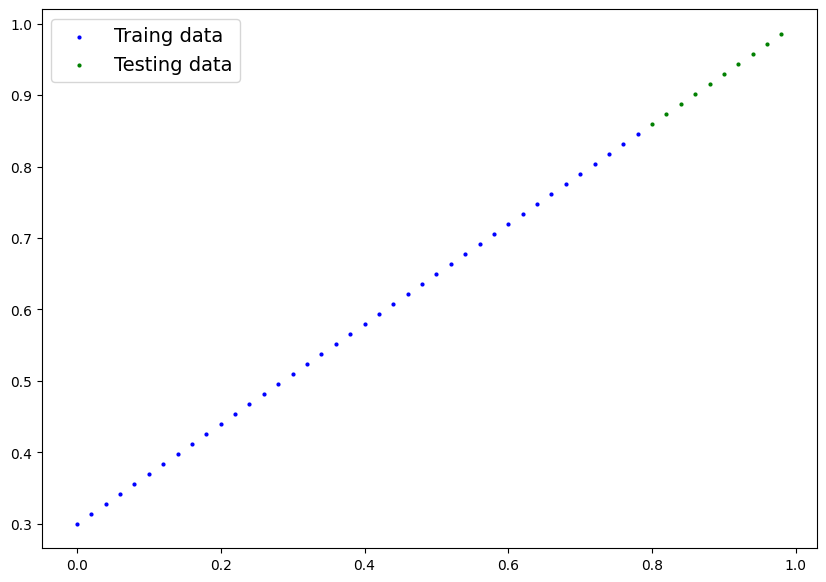

In [68]:
plot_predictions()

In [69]:
torch.randn(4,2)

tensor([[ 0.2345,  0.2303],
        [-1.1229, -0.1863],
        [ 2.2082, -0.6380],
        [ 0.4617,  0.2674]])

## 2. Build Model

create a linear  regression model class

In [70]:
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  """Linear Regression Model"""

  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    # Foward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias


### Pytorch Model Bilding essentials
- torch.nn - copntains all of the building blocks for computational graphs
- torch.nn.Parameter - what parameters shoul our model try and learn, often a PyTorch layer will set it for us
- torch.nn.Module - The base class for all NN modules. If you subclass it, you should override forward()
- torch.optim - this is where the optimizers live in PyTorch
- def forward - All nn.Module subclasses require you to override forward, this method defines what hanppens in the foward computation (output calculation)

### Checking the contents of our PyTorch model
- we cn check our model parameters using `.parameters()`



In [238]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [239]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`
When we pass data through our model as `model(X)` it will run through the forward method.



In [240]:
with torch.inference_mode(): ## torch.no_grad() also works similar
  y_preds = model_0(X_test)

list(zip(y_preds, y_test))

[(tensor([0.3982]), tensor([0.8600])),
 (tensor([0.4049]), tensor([0.8740])),
 (tensor([0.4116]), tensor([0.8880])),
 (tensor([0.4184]), tensor([0.9020])),
 (tensor([0.4251]), tensor([0.9160])),
 (tensor([0.4318]), tensor([0.9300])),
 (tensor([0.4386]), tensor([0.9440])),
 (tensor([0.4453]), tensor([0.9580])),
 (tensor([0.4520]), tensor([0.9720])),
 (tensor([0.4588]), tensor([0.9860]))]

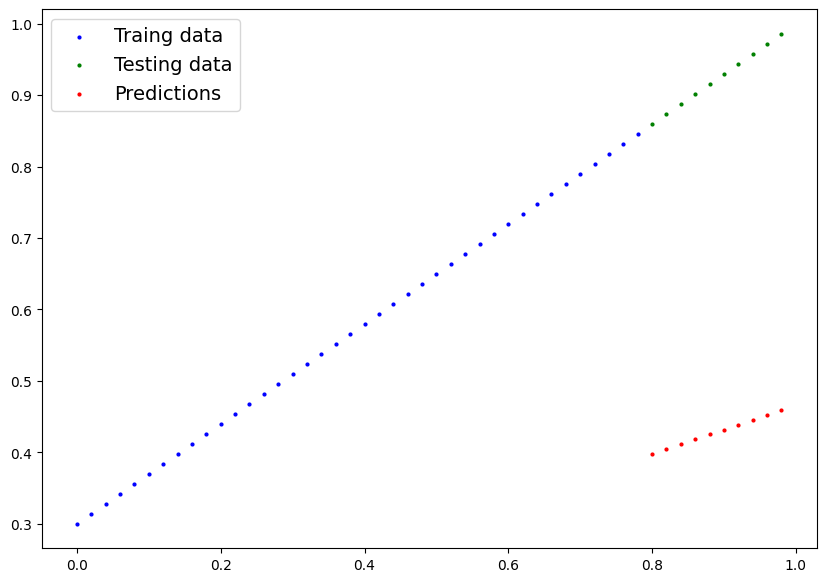

In [241]:
plot_predictions(predictions=y_preds)

## 3. Train model:
adjusting the model parameters such that the loss is minimized.
the new representation when the loss is minimized gives a better representation for the training data.

i.e a loss function is used to asssess the quality of each representations

Things needed for training:
- **loss function**
- **optimizer**

And specifically for PyTorch we need:
- A training loop
- A testing loop

In [242]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [243]:
# Setup our loss func:
loss_fn = nn.L1Loss()

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)


In [244]:
loss_fn, optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

### Building a training loop in PyTorch

A couple of things we need:
0. Loop through the data
1. forward  pass - to calculate model's predictions and the computation graph building behind the scenes by PyTorch
2. Calculate loss on this set of the fwd pass prediction with the current set of parameters
3. Optimizer zero grad
4. loss backward - moves backward to calculate the gradients wrt loss for model parameters  (**backpropogation**)
5. Optimizer step - use the optimizer to adjust the model prameters to improve loss (**gradient descent**)

In [245]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [246]:
torch.manual_seed(42)


# An epoch is one loop through the data ...
epochs = 200
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train mode in PyTorch sets alll parameters that requires_grad to require gradients

  # 1. forward pass
  y_pred = model_0(X_train)

  #2. calculate loss
  loss = loss_fn(y_pred, y_train) # (inputs, targets)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform bp on th eloss wrt the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gd)
  optimizer.step()

  #print(f"Training Loss: {loss}")


  ### Testing
  model_0.eval() # turns off gradient tracking

  with torch.inference_mode():
    # 1. fwd pass:
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Training Loss: {loss} | Test loss: {test_loss}")


  #

Epoch: 0 | Training Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Training Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Training Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Training Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Training Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Training Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Training Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Training Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Training Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Training Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Training Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Training Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Training Loss: 0.017585465

In [247]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [248]:
weight, bias

(0.7, 0.3)

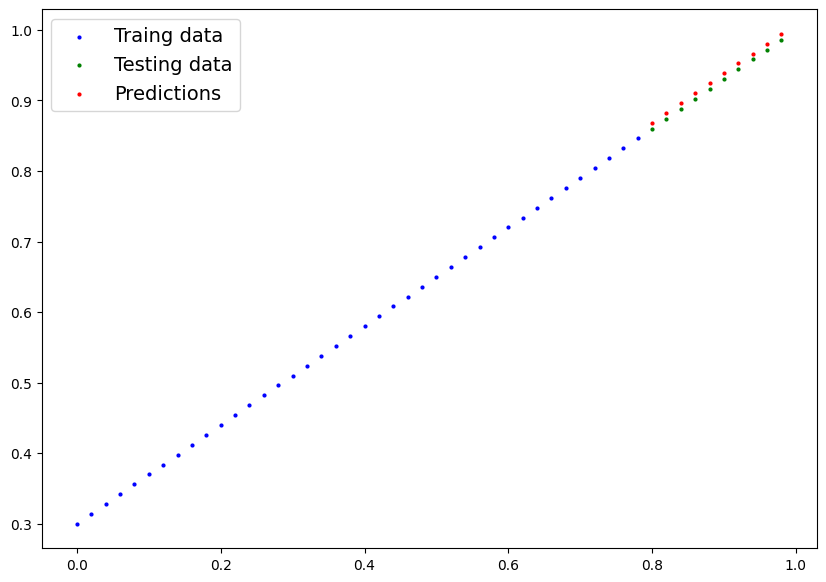

In [249]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

In [250]:
epoch_count, loss_values, test_loss_values

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190],
 [tensor(0.3129, grad_fn=<MeanBackward0>),
  tensor(0.1977, grad_fn=<MeanBackward0>),
  tensor(0.0891, grad_fn=<MeanBackward0>),
  tensor(0.0531, grad_fn=<MeanBackward0>),
  tensor(0.0454, grad_fn=<MeanBackward0>),
  tensor(0.0417, grad_fn=<MeanBackward0>),
  tensor(0.0382, grad_fn=<MeanBackward0>),
  tensor(0.0348, grad_fn=<MeanBackward0>),
  tensor(0.0313, grad_fn=<MeanBackward0>),
  tensor(0.0279, grad_fn=<MeanBackward0>),
  tensor(0.0245, grad_fn=<MeanBackward0>),
  tensor(0.0210, grad_fn=<MeanBackward0>),
  tensor(0.0176, grad_fn=<MeanBackward0>),
  tensor(0.0142, grad_fn=<MeanBackward0>),
  tensor(0.0107, grad_fn=<MeanBackward0>),
  tensor(0.0073, grad_fn=<MeanBackward0>),
  tensor(0.0039, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>)],
 [tensor(

In [251]:
import numpy as np


In [252]:
loss_values

[tensor(0.3129, grad_fn=<MeanBackward0>),
 tensor(0.1977, grad_fn=<MeanBackward0>),
 tensor(0.0891, grad_fn=<MeanBackward0>),
 tensor(0.0531, grad_fn=<MeanBackward0>),
 tensor(0.0454, grad_fn=<MeanBackward0>),
 tensor(0.0417, grad_fn=<MeanBackward0>),
 tensor(0.0382, grad_fn=<MeanBackward0>),
 tensor(0.0348, grad_fn=<MeanBackward0>),
 tensor(0.0313, grad_fn=<MeanBackward0>),
 tensor(0.0279, grad_fn=<MeanBackward0>),
 tensor(0.0245, grad_fn=<MeanBackward0>),
 tensor(0.0210, grad_fn=<MeanBackward0>),
 tensor(0.0176, grad_fn=<MeanBackward0>),
 tensor(0.0142, grad_fn=<MeanBackward0>),
 tensor(0.0107, grad_fn=<MeanBackward0>),
 tensor(0.0073, grad_fn=<MeanBackward0>),
 tensor(0.0039, grad_fn=<MeanBackward0>),
 tensor(0.0089, grad_fn=<MeanBackward0>),
 tensor(0.0089, grad_fn=<MeanBackward0>),
 tensor(0.0089, grad_fn=<MeanBackward0>)]

##### Using a `for` loop

This is a simple and explicit way to iterate over a list and apply a function to each element. You can either modify the list in-place (if the elements are mutable) or create a new list with the results.

In [ ]:
def square(x):
  return x * x

my_list = [1, 2, 3, 4, 5]
results_for_loop = []

for item in my_list:
  results_for_loop.append(square(item))

print(f"Original list: {my_list}")
print(f"Results using for loop: {results_for_loop}")

##### Using List Comprehension

List comprehensions provide a concise way to create lists. It's often more Pythonic and efficient than a `for` loop for creating new lists.

In [ ]:
def double(x):
  return x * 2

my_list = [10, 20, 30, 40, 50]

results_list_comp = [double(item) for item in my_list]

print(f"Original list: {my_list}")
print(f"Results using list comprehension: {results_list_comp}")

##### Using the `map()` function

The `map()` function applies a given function to all items in an iterable (like a list) and returns a map object (an iterator). You typically convert it to a list to view the results.

In [ ]:
def add_one(x):
  return x + 1

my_list = [100, 200, 300]

results_map = list(map(add_one, my_list))

# You can also use a lambda function with map for simple operations
results_map_lambda = list(map(lambda x: x - 5, my_list))

print(f"Original list: {my_list}")
print(f"Results using map() with a defined function: {results_map}")
print(f"Results using map() with a lambda function: {results_map_lambda}")

In [253]:
#loss_values = [torch.detach(loss) for loss in loss_values]
loss_values = list(map(torch.detach, loss_values))
loss_values

[tensor(0.3129),
 tensor(0.1977),
 tensor(0.0891),
 tensor(0.0531),
 tensor(0.0454),
 tensor(0.0417),
 tensor(0.0382),
 tensor(0.0348),
 tensor(0.0313),
 tensor(0.0279),
 tensor(0.0245),
 tensor(0.0210),
 tensor(0.0176),
 tensor(0.0142),
 tensor(0.0107),
 tensor(0.0073),
 tensor(0.0039),
 tensor(0.0089),
 tensor(0.0089),
 tensor(0.0089)]

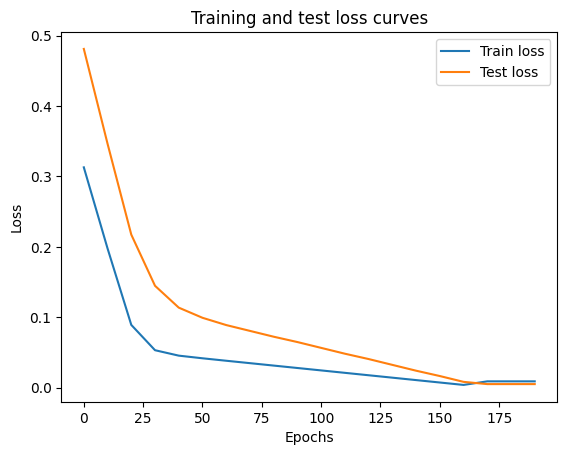

In [254]:
# Plot loss curves
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();


## Saving a model in PyTorch

3 main methods for saving and loading models in PyTorch

```
1. torch.save() - allows you to save in py pickle format
```

```
2. torch.load() - allows you to load a saved PyTorch onj
```
```
3. torch.nn.Module.load_state_dict() - allows to load a model's saved state dictionary
```




In [266]:
from pathlib import Path

# 1. Create model directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(),
           MODEL_SAVE_PATH)

saving model to: models/01_pytorch_workflow_model_0.pth


In [267]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [268]:
MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model_0.pth')

In [269]:
!ls -l models

total 4
-rw-r--r-- 1 root root 2117 Dec 15 16:08 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's state_dict() rather than the entire model, we'l;l create a new instance of the model class and load the saved state_dict() into that.

In [270]:
# To load in a saved state_dict, we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict, this will update the new instance with the loaded model's state_dict
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [271]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [273]:
# make some predictions with our loaded model

loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [276]:
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Everything in one place

In [277]:
# import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'2.9.0+cpu'

Create device agnostic code.

This means that if we';ve got access to a GPU, our code will use it. If not, the code will default to using CPU

In [278]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### 6.1 Data